In [1]:
import sys
sys.path.insert(1, '../model')
import model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter
import optuna
optuna.logging.disable_default_handler()
import pandas as pd
pd.plotting.register_matplotlib_converters()
import seaborn as sns
from scipy.integrate import solve_ivp

In [3]:
raw = pd.read_csv("../data/covid_19_data.csv")

In [4]:
raw

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
14806,14807,04/13/2020,Wyoming,US,2020-04-13 23:15:42,275.0,1.0,0.0
14807,14808,04/13/2020,Xinjiang,Mainland China,2020-04-13 23:15:42,76.0,3.0,73.0
14808,14809,04/13/2020,Yukon,Canada,2020-04-13 23:15:42,8.0,0.0,0.0
14809,14810,04/13/2020,Yunnan,Mainland China,2020-04-13 23:15:42,184.0,2.0,174.0


In [5]:
data_cols = ["Infected", "Deaths", "Recovered"]
data_cols_all = ["Confirmed", "Infected", "Deaths", "Recovered"]
df = raw.rename({"ObservationDate": "Date", "Province/State": "Province"}, axis=1)
df["Date"] = pd.to_datetime(df["Date"])
df["Country"] = df["Country/Region"]
df.loc[df["Country"] == "Diamond Princess", ["Country", "Province"]] = ["Others", "Diamond Princess"]
df["Infected"] = df["Confirmed"] - df["Deaths"] - df["Recovered"]
df[data_cols_all] = df[data_cols_all].astype(np.int64)
ncov_df_ungrouped = df.loc[:, ["Date", "Country", "Province", *data_cols_all]]
ncov_df_ungrouped.tail()

,Date,Country,Province,Confirmed,Infected,Deaths,Recovered
14806,2020-04-13,US,Wyoming,275,274,1,0
14807,2020-04-13,Mainland China,Xinjiang,76,0,3,73
14808,2020-04-13,Canada,Yukon,8,8,0,0
14809,2020-04-13,Mainland China,Yunnan,184,8,2,174
14810,2020-04-13,Mainland China,Zhejiang,1267,27,1,1239


In [6]:
df_germany = ncov_df_ungrouped.loc[ncov_df_ungrouped["Country"] == "Germany", :].groupby("Date").sum()
df_germany['Country'] = 'Germany'
df_germany['Province'] = None
df_germany

,Confirmed,Infected,Deaths,Recovered,Country,Province
Date,,,,,,
2020-01-28,4,4,0,0,Germany,None
2020-01-29,4,4,0,0,Germany,None
2020-01-30,4,4,0,0,Germany,None
2020-01-31,5,5,0,0,Germany,None
2020-02-01,8,8,0,0,Germany,None
...,...,...,...,...,...,...
2020-04-09,118181,63167,2607,52407,Germany,None
2020-04-10,122171,65491,2767,53913,Germany,None
2020-04-11,124908,64772,2736,57400,Germany,None


In [7]:
df_test = pd.read_csv("../data/full-list-total-tests-for-covid-19.csv")
df_test.rename({"Cumulative total tests": "TotalTests"}, axis=1,inplace=True)
df_test["Date"] = pd.to_datetime(df_test["Date"])
df_test_germany = df_test[df_test['Entity'] == 'Germany']
df_test_germany.tail()

,Entity,Code,Date,TotalTests
440,Germany,DEU,2020-03-08,87863
441,Germany,DEU,2020-03-15,215320
442,Germany,DEU,2020-03-22,563939
443,Germany,DEU,2020-03-29,924903
444,Germany,DEU,2020-04-05,1317887


In [8]:
result = pd.merge(df_germany,
                 df_test_germany[['Date','TotalTests']],
                 on='Date',
                 how = 'left')
from numpy import isnan
result.loc[0, ('TotalTests')] = 0 if isnan(result['TotalTests'][0]) else result['TotalTests'][0]
result['TotalTests'].interpolate(method='linear',inplace=True,limit_direction='both')
result['TotalTests'] = result['TotalTests'].astype(int)
result


,Date,Confirmed,Infected,Deaths,Recovered,Country,Province,TotalTests
0,2020-01-28,4,4,0,0,Germany,None,0
1,2020-01-29,4,4,0,0,Germany,None,2196
2,2020-01-30,4,4,0,0,Germany,None,4393
3,2020-01-31,5,5,0,0,Germany,None,6589
4,2020-02-01,8,8,0,0,Germany,None,8786
...,...,...,...,...,...,...,...,...
72,2020-04-09,118181,63167,2607,52407,Germany,None,1317887
73,2020-04-10,122171,65491,2767,53913,Germany,None,1317887
74,2020-04-11,124908,64772,2736,57400,Germany,None,1317887
75,2020-04-12,127854,64532,3022,60300,Germany,None,1317887


In [9]:
ger_scenario = model.Scenario(result, name="Germany", places=[("Germany", None)])

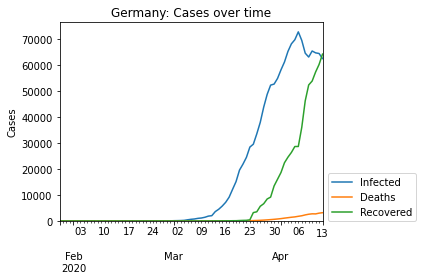

,Date,Confirmed,Infected,Deaths,Recovered
72,2020-04-09,118181,63167,2607,52407
73,2020-04-10,122171,65491,2767,53913
74,2020-04-11,124908,64772,2736,57400
75,2020-04-12,127854,64532,3022,60300
76,2020-04-13,130072,62578,3194,64300


In [10]:
ger_scenario.show_record().tail()

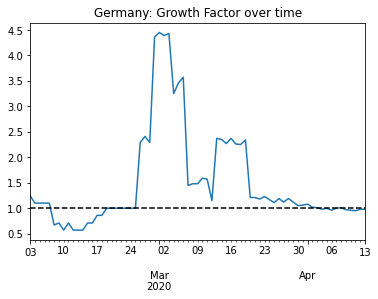

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Germany,2020-04-13,Crossroad,0,5


In [11]:
ger_scenario.growth_factor()

In [12]:
result.loc[result['Date'] == '2020-02-25']

,Date,Confirmed,Infected,Deaths,Recovered,Country,Province,TotalTests
28,2020-02-25,17,3,0,14,Germany,None,61504


In [13]:
result.loc[result['Date'] == '2020-04-13']

,Date,Confirmed,Infected,Deaths,Recovered,Country,Province,TotalTests
76,2020-04-13,130072,62578,3194,64300,Germany,None,1317887


In [14]:
ger_scenario.set_phase(
    start_dates=["25Feb2020", "22Mar2020","10Apr2020"],
    population=82790000
)

,start_date,end_date,population
1st,25Feb2020,21Mar2020,82790000
2nd,22Mar2020,09Apr2020,82790000
3rd,10Apr2020,-,82790000


In [15]:
ger_scenario.estimate(model.SIR)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 7 sec.
		100 trials finished in 0 min 10 sec.
		100 trials finished in 0 min 12 sec.
		100 trials finished in 0 min 13 sec.
		100 trials finished in 0 min 14 sec.
	Successfully estimated.
Hyperparameter estimation of 2nd phase.
	Estimator was created.
		100 trials finished in 0 min 6 sec.
	Successfully estimated.
Hyperparameter estimation of 3rd phase.
	Estimator was created.
		100 trials finished in 0 min 6 sec.
	Successfully estimated.
Total: 1 min 13 sec.


In [16]:
ger_scenario.show_parameters()

,start_date,end_date,population,tau,rho,sigma,Rt,score,1/beta [day],1/gamma [day]
1st,25Feb2020,21Mar2020,82790000,804,0.226431,0.001275,177.61,0.606492,2,437
2nd,22Mar2020,09Apr2020,82790000,804,0.066212,0.030583,2.16,0.172864,8,18
3rd,10Apr2020,-,82790000,804,0.024951,0.034002,0.73,0.007496,22,16


../model/model.py:762: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



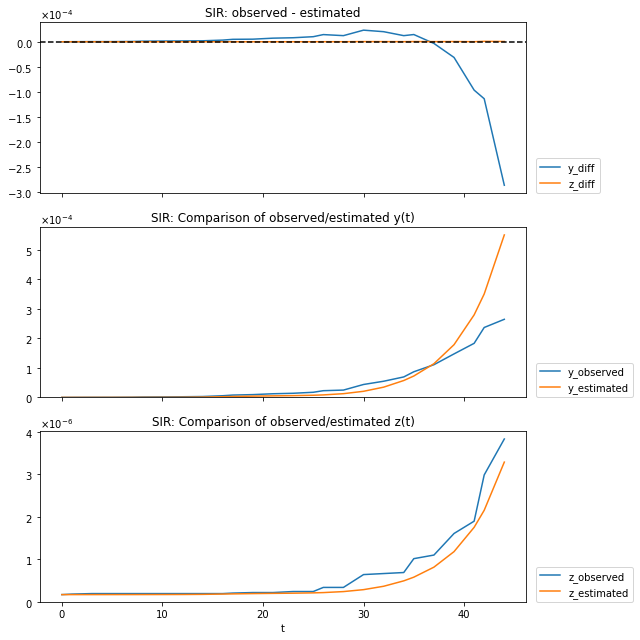

In [17]:
ger_scenario.accuracy_graph(phase_n=1)

../model/model.py:762: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



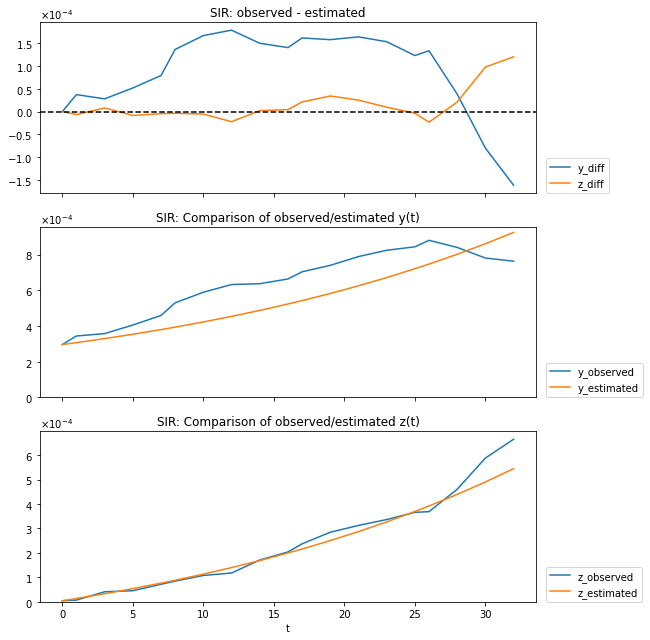

In [18]:
ger_scenario.accuracy_graph(phase_n=2)

../model/model.py:762: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



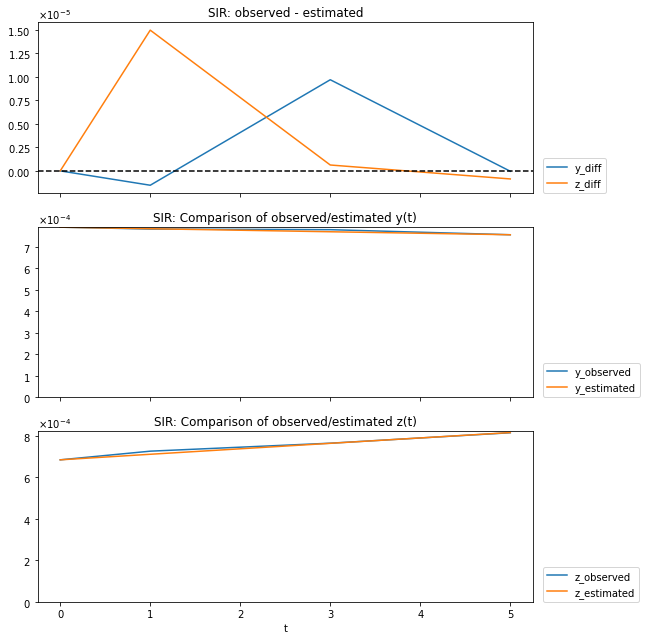

In [19]:
ger_scenario.accuracy_graph(phase_n=3)

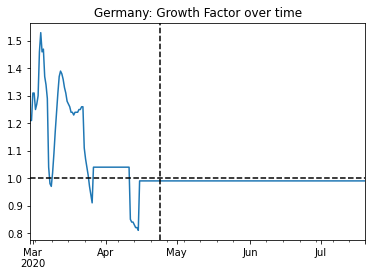

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Germany,2020-07-19 17:24:00,Stopping,0,179


In [20]:
ger_scenario.growth_factor(days_to_predict=100)

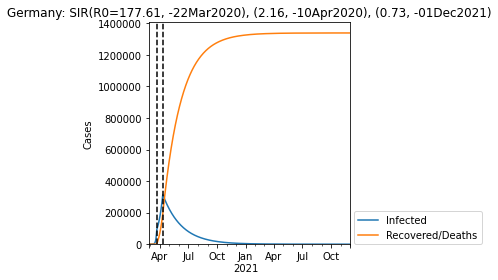

In [21]:
df = ger_scenario.predict(days=600)

In [22]:
df.loc['2020-04-09':'2020-04-12']

,Susceptible,Infected,Recovered/Deaths
Time,,,
2020-04-09 02:36:00,82340831,282912,166255
2020-04-09 16:00:00,82321871,293066,175062
2020-04-10 05:24:00,82302234,303580,184184
2020-04-10 18:48:00,82281898,314466,193635
2020-04-11 08:12:00,82274136,311584,204278
2020-04-11 21:36:00,82266446,308728,214824
2020-04-12 11:00:00,82258828,305898,225273


SEIR MODEL

In [23]:
ger_scenario.set_phase(
    start_dates=["25Feb2020", "22Mar2020","11Apr2020"],
    population=82790000
)

,start_date,end_date,population
1st,25Feb2020,21Mar2020,82790000
2nd,22Mar2020,10Apr2020,82790000
3rd,11Apr2020,-,82790000


In [24]:
ger_scenario.estimate(model.SIRD)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 8 sec.
		100 trials finished in 0 min 10 sec.
		100 trials finished in 0 min 13 sec.
		100 trials finished in 0 min 14 sec.
		100 trials finished in 0 min 17 sec.
		100 trials finished in 0 min 19 sec.
	Successfully estimated.
Hyperparameter estimation of 2nd phase.
	Estimator was created.
		100 trials finished in 0 min 8 sec.
	Successfully estimated.
Hyperparameter estimation of 3rd phase.
	Estimator was created.
		100 trials finished in 0 min 8 sec.
	Successfully estimated.
Total: 1 min 41 sec.


In [25]:
ger_scenario.show_parameters()

,start_date,end_date,population,tau,kappa,rho,sigma,Rt,score,1/alpha2 [day],1/beta [day],1/gamma [day]
1st,25Feb2020,21Mar2020,82790000,806,0.000372,0.224990,0.001164,146.45,0.652502,1503,2,480
2nd,22Mar2020,10Apr2020,82790000,806,0.001571,0.065655,0.030624,2.04,0.225753,356,8,18
3rd,11Apr2020,-,82790000,806,0.002469,0.027196,0.036109,0.70,0.015900,226,20,15


../model/model.py:762: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



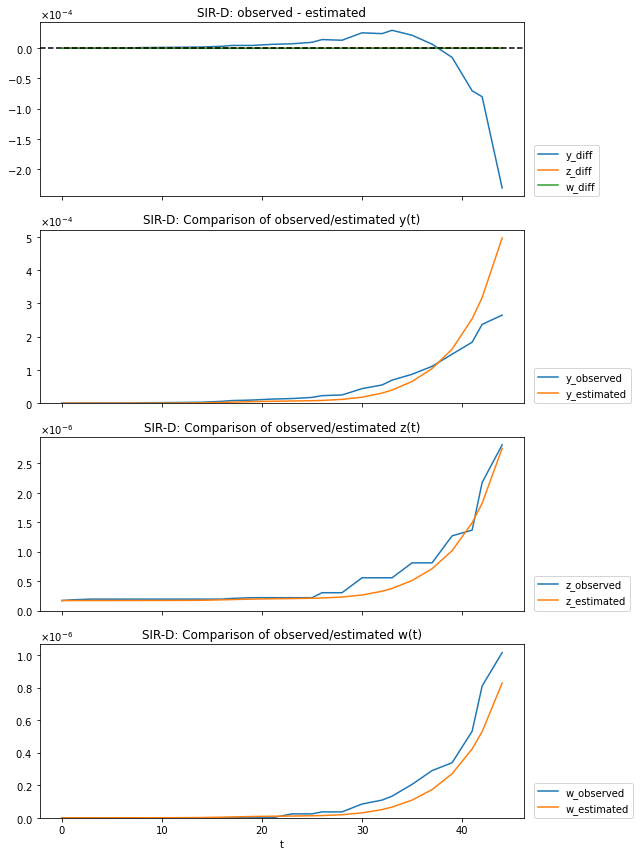

In [26]:
ger_scenario.accuracy_graph(phase_n=1)

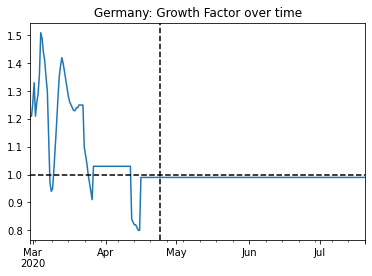

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Germany,2020-07-20 02:06:00,Stopping,0,178


In [27]:
ger_scenario.growth_factor(days_to_predict=100)

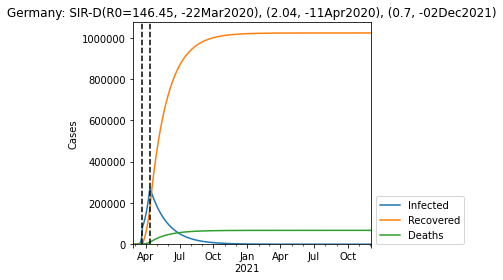

In [28]:
df = ger_scenario.predict(days=600)

In [29]:
df.loc['2020-04-09':'2020-04-12']

,Susceptible,Infected,Recovered,Deaths
Time,,,,
2020-04-09 05:14:00,82398637,239128,144697,7536
2020-04-09 18:40:00,82382751,247186,152143,7918
2020-04-10 08:06:00,82366333,255513,159840,8313
2020-04-10 21:32:00,82349365,264117,167795,8721
2020-04-11 10:58:00,82331830,273006,176019,9143
2020-04-12 00:24:00,82324489,269875,185821,9813
2020-04-12 13:50:00,82317233,266780,195510,10475


SEIRD MODEL

In [30]:
ger_scenario.estimate(model.SIRF)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 10 sec.
		100 trials finished in 0 min 11 sec.
		100 trials finished in 0 min 13 sec.
		100 trials finished in 0 min 15 sec.
	Estimator will be replaced because estimated z is non-monotonic.
	Estimator was created.
		100 trials finished in 0 min 9 sec.
		100 trials finished in 0 min 11 sec.
		100 trials finished in 0 min 12 sec.
		100 trials finished in 0 min 14 sec.
		100 trials finished in 0 min 14 sec.
		100 trials finished in 0 min 15 sec.
		100 trials finished in 0 min 20 sec.
		100 trials finished in 0 min 21 sec.
		100 trials finished in 0 min 23 sec.
		100 trials finished in 0 min 24 sec.
		100 trials finished in 0 min 24 sec.
	Estimator will be replaced because it is incapable of improvement.
	Estimator was created.
		100 trials finished in 0 min 8 sec.
		100 trials finished in 0 min 10 sec.
		100 trials finished in 0 min 12 sec.
		100 trials finished in 0 min 14 sec.
		100 trials fi

In [31]:
ger_scenario.show_parameters()

,start_date,end_date,population,tau,theta,kappa,rho,sigma,Rt,score,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day]
1st,25Feb2020,21Mar2020,82790000,774,0.000446,0.000269,0.211454,0.001043,161.09,0.703802,0.000,2000,2,515
2nd,22Mar2020,10Apr2020,82790000,774,0.017863,0.000564,0.061524,0.027824,2.13,0.241618,0.018,953,8,19
3rd,11Apr2020,-,82790000,774,0.050757,0.000669,0.033368,0.038814,0.80,0.017012,0.051,803,16,13


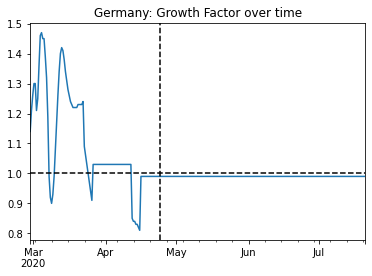

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Germany,2020-07-20 17:42:00,Stopping,0,186


In [32]:
ger_scenario.growth_factor(days_to_predict=100)

In [33]:
df.loc['2020-04-09':'2020-04-12']

,Susceptible,Infected,Recovered,Deaths
Time,,,,
2020-04-09 05:14:00,82398637,239128,144697,7536
2020-04-09 18:40:00,82382751,247186,152143,7918
2020-04-10 08:06:00,82366333,255513,159840,8313
2020-04-10 21:32:00,82349365,264117,167795,8721
2020-04-11 10:58:00,82331830,273006,176019,9143
2020-04-12 00:24:00,82324489,269875,185821,9813
2020-04-12 13:50:00,82317233,266780,195510,10475


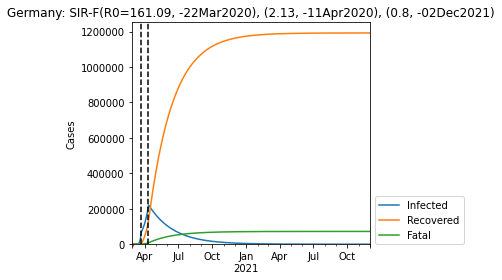

In [34]:
df = ger_scenario.predict(days=600)

SEWIRF

In [35]:
ger_scenario.estimate(model.SEWIRF)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 10 sec.
	Estimator will be replaced because estimated w is non-monotonic.
	Estimator was created.
		100 trials finished in 0 min 9 sec.
		100 trials finished in 0 min 10 sec.
	Estimator will be replaced because estimated z is non-monotonic.
	Estimator was created.
		100 trials finished in 0 min 11 sec.
	Estimator will be replaced because estimated z is non-monotonic.
	Estimator was created.
		100 trials finished in 0 min 10 sec.
		100 trials finished in 0 min 11 sec.
		100 trials finished in 0 min 12 sec.
		100 trials finished in 0 min 15 sec.
		100 trials finished in 0 min 15 sec.
\excveeded max number of tires estimated.
Hyperparameter estimation of 2nd phase.
	Estimator was created.
		100 trials finished in 0 min 8 sec.
		100 trials finished in 0 min 9 sec.
		100 trials finished in 0 min 11 sec.
		100 trials finished in 0 min 14 sec.
		100 trials finished in 0 min 13 sec.
		100 trials fini

In [36]:
ger_scenario.show_parameters()

,start_date,end_date,population,tau,theta,kappa,rho1,rho2,rho3,sigma,Rt,score,alpha1 [-],1/alpha2 [day],1/beta1 [day],1/beta2 [day],1/beta3 [day],1/gamma [day]
1st,25Feb2020,21Mar2020,82790000,1404,0.552259,0.000037,0.426674,0.326205,0.018373,0.001122,164.85,3.221700,0.552,26114,2,2,53,869
2nd,22Mar2020,10Apr2020,82790000,1404,0.017495,0.000672,0.204318,0.327473,0.757282,0.055676,3.56,0.285493,0.017,1451,4,2,1,17
3rd,11Apr2020,-,82790000,1404,0.794436,0.000139,0.086694,0.754511,0.142805,0.053085,0.33,0.039735,0.794,7000,11,1,6,18


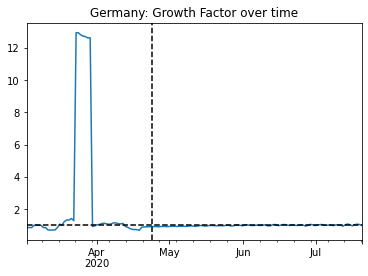

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Germany,2020-07-20 06:00:00,Crossroad,0,0


In [37]:
ger_scenario.growth_factor(days_to_predict=100)

In [41]:
df.loc['2020-04-09':]

,Susceptible,Infected,Recovered,Fatal,Exposed,Waiting,Confirmed
Time,,,,,,,
2020-04-09 20:24:00,82768564,9479,4197,346,5409,2001,14022
2020-04-10 19:48:00,82766089,10415,4760,379,6017,2337,15554
2020-04-11 19:12:00,82763339,11527,5379,418,6690,2644,17324
2020-04-12 18:36:00,82761979,11056,5978,920,4050,6014,17954
2020-04-13 18:00:00,82760431,10683,6555,1715,3064,7549,18953
...,...,...,...,...,...,...,...
2020-07-17 07:48:00,82615078,5365,41652,117247,1661,8994,164264
2020-07-18 07:12:00,82613841,5342,41936,118263,1626,8988,165541
2020-07-19 06:36:00,82612599,5324,42219,119287,1678,8890,166830


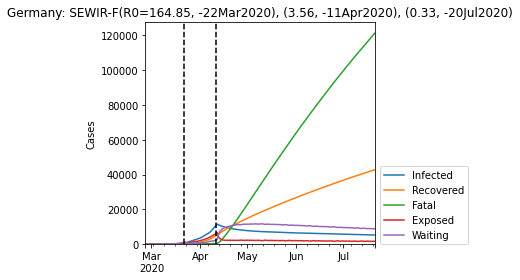

In [40]:
df = ger_scenario.predict(days=100)

PREDICTING IN PHASES

TRYING TO INCLUDE TESTS